In [ ]:
import pandas as pd
import numpy as np
import tqdm
import pickle

import nbimporter
from tfidf import LyricsTFIDF
from utils import plot_vectors

from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# LyricsClustering CLASS 

In [ ]:
class LyricsClustering():
    
    
    def __init__(self, lyrics_df, preprocessed_corpus):
        
        self.lyrics_df = lyrics_df
        self.preprocessed_corpus = preprocessed_corpus
        self.tfidf_model = LyricsTFIDF(lyrics_df, preprocessed_corpus)
        self.tfidf_matrix_reduced = None
        
        
    def tfidf_matrix(self, preprocessed_corpus=None, ngram_range=(1,1), **kwargs):
        
        tfidf_dataframe = self.tfidf_model.fit_transform(preprocessed_corpus=preprocessed_corpus, ngram_range=ngram_range, **kwargs)
        self.tfidf_matrix = self.tfidf_model.tfidf_matrix
        
        return self.tfidf_matrix
    
    
    def reduce_dimensionality(self, method, num_components, tfidf_matrix):
                
        # returns U,S,V if 'svd' or W, H if 'nmf'
        blocks = self.tfidf_model.matrix_factorization(method, num_components, tfidf_matrix)
        self.tfidf_matrix_reduced = blocks[0]
        
        return blocks[0]
        
    
    def guess_num_clusters(self, tfidf_matrix, sample_size=15000, reduction_components=300):
        
        # reduce the dimensionality of the input, to speed up clustering
        tfidf_matrix_reduced = self.reduce_dimensionality(method='svd', num_components=reduction_components, tfidf_matrix=tfidf_matrix)
        
        # Use agglomerative clustering to guess a likely number of cluster present in the data
        sample = np.random.choice(tfidf_matrix_reduced.shape[0], replace=False, size=sample_size)
        linkage_matrix = linkage(tfidf_matrix_reduced[sample], method='ward')

        row_dendrogram = dendrogram(linkage_matrix)
        plt.tight_layout()
        plt.ylabel('Euclidean distance')
        plt.show()
    
    
    def find_centroids(self, num_clusters, tfidf_matrix=None, reduction_components=300, sample_size=15000):
        
        if tfidf_matrix is None:
            tfidf_matrix = self.tfidf_matrix

        if self.tfidf_matrix_reduced is None: 
            # reduce the dimensionality of the input, to speed up clustering
            tfidf_matrix_reduced = self.reduce_dimensionality(method='svd', num_components=reduction_components, 
                                                              tfidf_matrix=tfidf_matrix)
        else:
            tfidf_matrix_reduced = self.tfidf_matrix_reduced
            
        # clustering on a subset of whole data
        agg = AgglomerativeClustering(n_clusters=num_clusters)
        sample = np.random.choice(tfidf_matrix_reduced.shape[0], replace=False, size=sample_size)
        agg_sample_ids = agg.fit_predict(tfidf_matrix_reduced[sample])     
        
        # find centroids
        centroids = np.array([tfidf_matrix_reduced[sample][agg_sample_ids == cluster].mean(axis=0) 
                              for cluster in range(num_clusters)])
        return centroids
    
    
    def k_means_clustering(self, num_clusters, centroids, tfidf_matrix_reduced=None):
        
        if tfidf_matrix_reduced is None:
            if self.tfidf_matrix_reduced is None:
                tfidf_matrix_reduced = self.reduce_dimensionality(method='svd', num_components=reduction_components, 
                                                                  tfidf_matrix=tfidf_matrix)
            else:
                tfidf_matrix_reduced = self.tfidf_matrix_reduced
        
        km = KMeans(n_clusters=num_clusters, n_jobs=-1, init=centroids)

        # fit
        km.fit(tfidf_matrix_reduced)
        
        self.k_means_model = km
        
    
    def plot_clusters(self, tfidf_matrix, dimensions, cluster_labels):
        
        if tfidf_matrix_reduced is None:
            # reduce dimensionality to plot
            tfidf_matrix_reduced = self.reduce_dimensionality(method='svd', num_components=dimensions, 
                                                              tfidf_matrix=tfidf_matrix)
        else:
            tfidf_matrix_reduced = self.tfidf_matrix_reduced
        
        %run utils.ipynb
        plot_vectors(tfidf_matrix_reduced, labels=self.km.labels_, dimensions=dimensions)
    
    
    def silhouette_scores(self, num_cluster_range, tfidf_matrix, sample_size, fig_size=(20, 10)):

        silhouettes = []
        
        print(f"Evaluating clusters in range {num_cluster_range} ...", flush=True)
        for c in tqdm(range(*num_cluster_range)):
            agg_clustering = AgglomerativeClustering(n_clusters=c)
            sample = np.random.choice(tfidf_matrix.shape[0], replace=False, size=sample_size)
            agg_cluster_ids = agg_clustering.fit_predict(tfidf_matrix[sample])

            score = silhouette_score(tfidf_matrix[sample], agg_cluster_ids)
            silhouettes.append(score)

        fig, ax = plt.subplots(figsize=fig_size)
        plt.plot(K, silhouettes, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Silhouette score')
        plt.title('Silhouette Method For Optimal k')
        plt.show()
        

## Analysis 

In [ ]:
lyrics_df = lyrics_df = pd.read_csv("./data/lyrics_cleaned.csv")

with open('./data/trimmed_corpus_old.pickle', 'rb') as pickled_object:
    trimmed_corpus = pickle.load(pickled_object)

In [ ]:
lyrics_clustering = LyricsClustering(lyrics_df, trimmed_corpus)

In [ ]:
tfidf_matrix = lyrics_clustering.tfidf_matrix(trimmed_corpus, ngram_range=(1, 3))
tfidf_matrix.shape

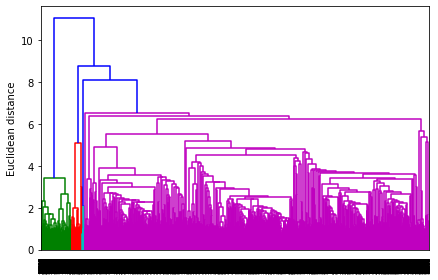

In [6]:
lyrics_clustering.guess_num_clusters(tfidf_matrix, sample_size=20000, reduction_components=500)

In [7]:
centroids = lyrics_clustering.find_centroids(num_clusters=4, tfidf_matrix=tfidf_matrix, reduction_components=500, sample_size=20000)

In [9]:
centroids.shape

(4, 500)

In [11]:
tfidf_matrix_reduced = lyrics_clustering.reduce_dimensionality(method='svd', num_components=500, tfidf_matrix=tfidf_matrix)
tfidf_matrix_reduced.shape

(43844, 500)

In [13]:
lyrics_clustering.k_means_clustering(4, centroids, tfidf_matrix_reduced)

/Users/lucamasserano/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [16]:
lyrics_clustering.k_means_model.labels_

array([1, 1, 1, ..., 0, 0, 0], dtype=int32)

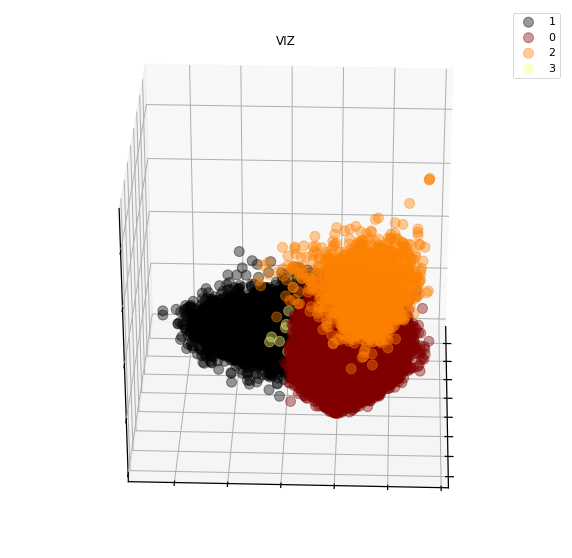

In [36]:
plot_vectors(tfidf_matrix_reduced, labels=lyrics_clustering.k_means_model.labels_, dimensions=3, view_init=(30, 182))

## Analysis of resulting clusters

### Cluster 0

In [43]:
label_df = lyrics_df.loc[lyrics_clustering.k_means_model.labels_ == 0, :]
for genre in label_df.genre.unique():
    print(genre, label_df.loc[label_df.genre == genre, :].shape)

Hip-Hop (1766, 7)
Rock (14176, 7)
Pop (8331, 7)
Folk (578, 7)
Electronic (1206, 7)
Reggae (187, 7)
Other (1401, 7)
Metal (1372, 7)
Jazz (1353, 7)
Gospel (561, 7)
Indie (552, 7)
Country (3556, 7)
R&B (1279, 7)


### Cluster 1

In [44]:
label_df = lyrics_df.loc[lyrics_clustering.k_means_model.labels_ == 1, :]
for genre in label_df.genre.unique():
    print(genre, label_df.loc[label_df.genre == genre, :].shape)

Hip-Hop (3731, 7)
Rock (453, 7)
Pop (691, 7)
Folk (7, 7)
Other (173, 7)
Gospel (17, 7)
Jazz (41, 7)
R&B (97, 7)
Reggae (4, 7)
Country (38, 7)
Electronic (74, 7)
Metal (27, 7)
Indie (12, 7)


In [52]:
cluster_1_corpus = np.array(lyrics_clustering.preprocessed_corpus)[
                lyrics_df.loc[lyrics_clustering.k_means_model.labels_ == 1, :].index
                ].tolist()
len(cluster_1_corpus)

5365

In [54]:
tfidf_cluster_1 = lyrics_clustering.tfidf_model.fit_transform(preprocessed_corpus=cluster_1_corpus,
                                                             save_attributes=False, ngram_range=(1,3), topn=30)
tfidf_cluster_1

Joining tokens for each lyrics ...


100%|██████████| 5365/5365 [00:00<00:00, 90793.13it/s]

Fitting TFIDF vectorizer ...


,ngram,tfidf
0,yeah,133.773345
1,bitch,128.983804
2,shit,118.777578
3,say,115.325276
4,make,114.993388
5,fuck,113.980026
6,nigga,111.712737
7,come,104.833993
8,let,99.330312
9,tell,98.222956


### Cluster 2

In [45]:
label_df = lyrics_df.loc[lyrics_clustering.k_means_model.labels_ == 2, :]
for genre in label_df.genre.unique():
    print(genre, label_df.loc[label_df.genre == genre, :].shape)

Hip-Hop (191, 7)
Rock (515, 7)
Pop (679, 7)
Electronic (70, 7)
Reggae (10, 7)
Other (77, 7)
Jazz (22, 7)
R&B (117, 7)
Indie (52, 7)
Folk (17, 7)
Country (66, 7)
Gospel (32, 7)
Metal (22, 7)


### Cluster 3 

In [46]:
label_df = lyrics_df.loc[lyrics_clustering.k_means_model.labels_ == 3, :]
for genre in label_df.genre.unique():
    print(genre, label_df.loc[label_df.genre == genre, :].shape)

Hip-Hop (24, 7)
Rock (101, 7)
Pop (95, 7)
Electronic (11, 7)
Other (23, 7)
Jazz (5, 7)
Gospel (3, 7)
R&B (9, 7)
Reggae (1, 7)
Country (6, 7)
Indie (7, 7)
Folk (3, 7)
Metal (3, 7)
